In [1]:
import pandas as pd
# data = pd.read_csv('russo_ukraine.csv', compression='gzip', dtype=str)

data_list_raw = []
for i in range(1, 20):
    filename = f'snsc_data/out_{i}.csv'
    print('Reading file:', filename)
    d = pd.read_csv(filename, compression='gzip', dtype=str)
    data_list_raw.append(d)

data = pd.concat(data_list_raw, axis=0, ignore_index=True)
data.shape

Reading file: snsc_data/out_1.csv
Reading file: snsc_data/out_2.csv
Reading file: snsc_data/out_3.csv
Reading file: snsc_data/out_4.csv
Reading file: snsc_data/out_5.csv
Reading file: snsc_data/out_6.csv
Reading file: snsc_data/out_7.csv
Reading file: snsc_data/out_8.csv
Reading file: snsc_data/out_9.csv
Reading file: snsc_data/out_10.csv
Reading file: snsc_data/out_11.csv
Reading file: snsc_data/out_12.csv
Reading file: snsc_data/out_13.csv
Reading file: snsc_data/out_14.csv
Reading file: snsc_data/out_15.csv
Reading file: snsc_data/out_16.csv
Reading file: snsc_data/out_17.csv
Reading file: snsc_data/out_18.csv
Reading file: snsc_data/out_19.csv


(1946105, 419)

In [2]:
# Remove tweets with invalid "create_at" time

data = data[data.created_at.str.contains(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\+00:00$')]

In [6]:
# Time range of the data

print(data.created_at.min())
print(data.created_at.max())

2022-03-17 10:05:14+00:00
2022-03-17 15:21:58+00:00


In [17]:
# Some analysis

data[data.entities_hashtags.str.contains('p2p', na=False)].text.to_list()

['#IDO #Airdrop #Whitelist #NFT #p2pquake',
 '#IDO #Airdrop #Whitelist #NFT #p2pquake']

In [7]:
# List all hashtags

import ast
all_hashtags_raw = data.query('entities_hashtags.notna() and entities_hashtags != "[]"').entities_hashtags.to_list()
all_hashtags_raw = list(map(lambda raw_str: ast.literal_eval(raw_str), all_hashtags_raw))
all_hashtags_count = {}
for hashtags_raw in all_hashtags_raw:
	hashtags = map(lambda d: d['text'].lower(), hashtags_raw)
	for hashtag in hashtags:
		if hashtag not in all_hashtags_count: all_hashtags_count[hashtag] = 0
		all_hashtags_count[hashtag] += 1
all_hashtags = list(all_hashtags_count.keys())
print('Num of distinct hashtags:', len(all_hashtags))

Num of distinct hashtags: 19852


In [8]:
# Remove non-English hashtags

import re
for hashtag in all_hashtags.copy():
	if re.search('[^0-9A-Za-z_]', hashtag) is not None:
		all_hashtags.remove(hashtag)
		all_hashtags_count.pop(hashtag)

print('Num of distinct English hashtags:', len(all_hashtags))

Num of distinct English hashtags: 16971


In [18]:
# Manually remove hashtags that are irrelevant

remove_hashtags = ['javascript', '100daysofcode', 'womenwhocode', 'coding', 'pytorch', 'java', 'airdrop', 'p2p']

for hashtag in remove_hashtags:
    if hashtag in all_hashtags:
        all_hashtags.remove(hashtag)
        all_hashtags_count.pop(hashtag)

In [19]:
# Filter top 1% frequent hashtags for analysis

all_hashtags_count_sorted = sorted(list(all_hashtags_count.items()), key=lambda pair: -pair[1])
num_top = int(len(all_hashtags) * 0.01)
target_hashtags_count = all_hashtags_count_sorted[:num_top]
target_hashtags_dict = dict(target_hashtags_count)
target_hashtags = list(map(lambda tup: tup[0], target_hashtags_count))

print(num_top)
print(target_hashtags_count)

169
[('ukraine', 69024), ('russia', 26764), ('putin', 14090), ('russian', 10028), ('ukrainian', 7166), ('mariupol', 7082), ('ukrainerussiawar', 7024), ('kyiv', 6192), ('standwithukraine', 5762), ('zelensky', 5228), ('nestle', 4981), ('stpatricksday', 4848), ('nato', 4620), ('nft', 4356), ('breaking', 3842), ('ukrainewar', 3312), ('usa', 3100), ('selenskyj', 3050), ('flagnetwork', 2896), ('ukraineunderattack', 2884), ('stoprussia', 2432), ('bitcoin', 2415), ('mykolaiv', 2376), ('bundestag', 2370), ('ireland', 2314), ('putinwarcriminal', 2312), ('biden', 2300), ('kherson', 2252), ('stopthewar', 2228), ('ucraina', 2172), ('stopwar', 2170), ('tigrayfamine', 2087), ('freeukraine', 1966), ('stopputin', 1934), ('russie', 1882), ('us', 1872), ('rusia', 1862), ('ido', 1848), ('ucrania', 1842), ('kharkiv', 1832), ('kiev', 1804), ('moldova', 1804), ('tigray', 1662), ('standwithukriane', 1642), ('russiaukrainewar', 1632), ('weareallukrainians', 1508), ('cryptocurrency', 1504), ('anonymous', 1500),

In [20]:
# Find co-occurrence numbers as edge weights
hashtag_pairs = {}

for hashtags_raw in all_hashtags_raw:
	if len(hashtags_raw) == 1: continue

	for xi in range(len(hashtags_raw) - 1):
		x = hashtags_raw[xi]['text'].lower()
		if x not in target_hashtags: continue
		for yi in range(xi + 1, len(hashtags_raw)):
			y = hashtags_raw[yi]['text'].lower()
			if y not in target_hashtags or x == y: continue

			tx, ty = (x, y) if x < y else (y, x)
			if (tx, ty) not in hashtag_pairs: hashtag_pairs[(tx, ty)] = 0
			hashtag_pairs[(tx, ty)] += 1

print('Num of edges:', len(hashtag_pairs))
print('Sum of all edge weights:', sum(hashtag_pairs.values()))

Num of edges: 3242
Sum of all edge weights: 247541


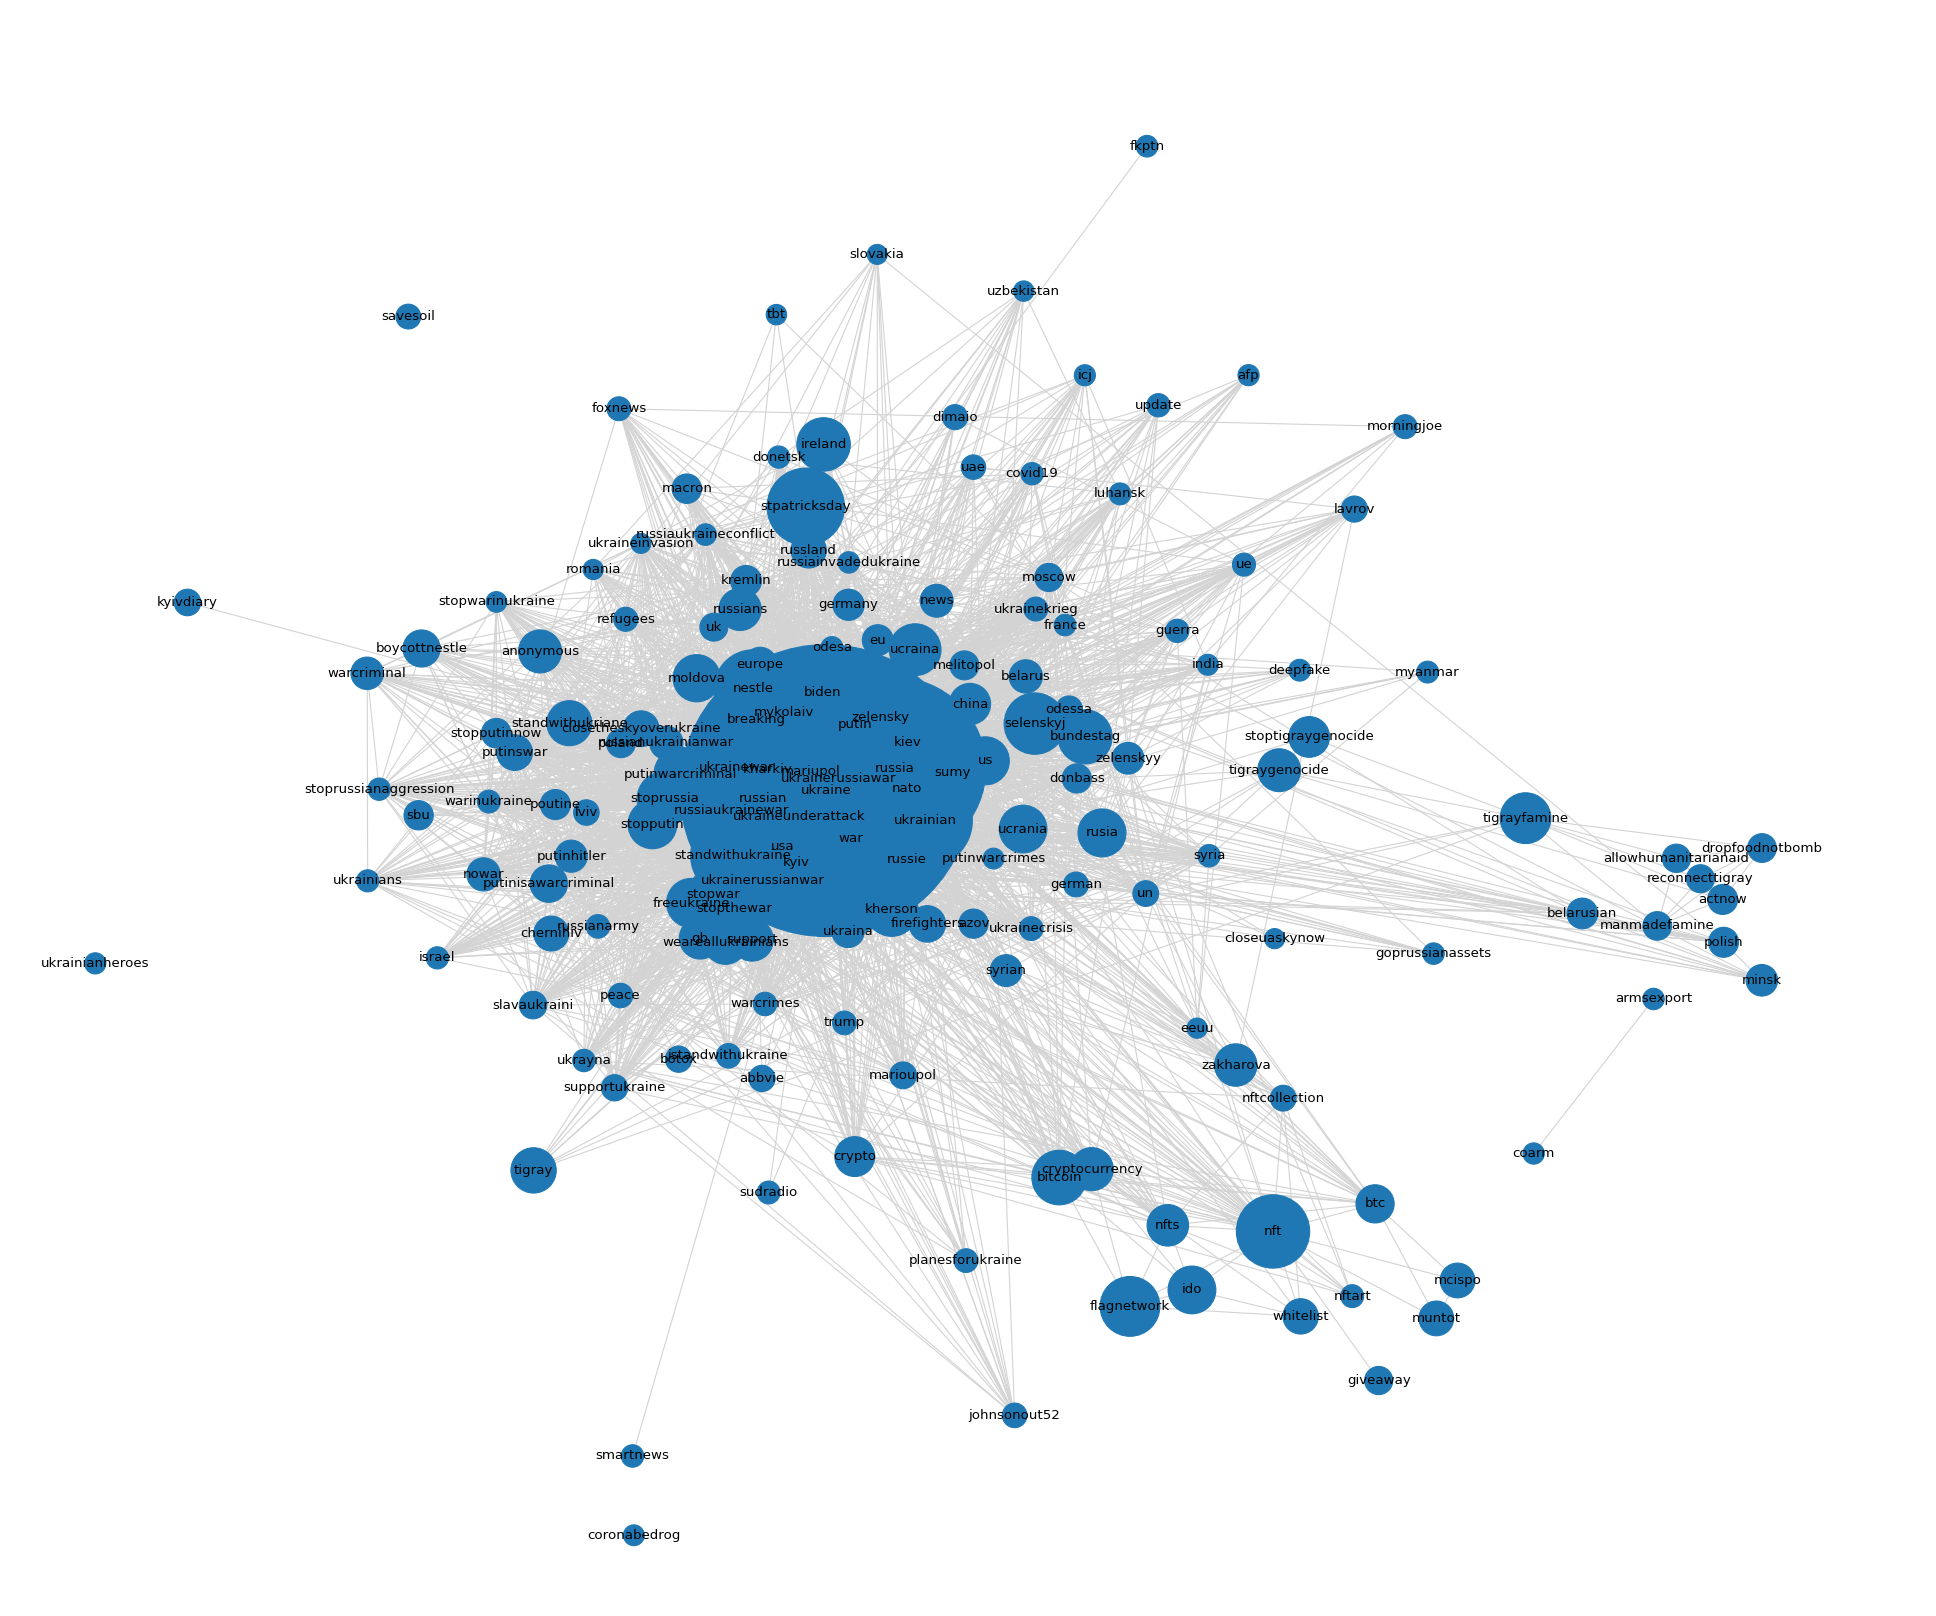

In [21]:
# Draw networkx graph
import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph()
for hashtag, count in target_hashtags_count:
	g.add_node(hashtag, weight=count)
for hashtag_pair, weight in hashtag_pairs.items():
	g.add_edge(*hashtag_pair, weight=weight)

pos = nx.spring_layout(g, k=2.2)
plt.figure(figsize=(24, 20), dpi=80)
nx.draw(
	g,
	pos=pos,
	with_labels=True,
	node_size=list(nx.get_node_attributes(g,'weight').values()),
	edge_color='lightgrey',
)